In [78]:
#Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sklearn 
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score, roc_auc_score
from sklearn.linear_model import Lasso

In [79]:
# Load dataset from csv file

data = pd.read_csv("week 4 - Nashville_housing_data.csv")

In [80]:
#########################   PART 1   #################################

In [83]:
# Understand dataset structure
print(data.shape)
print(data.dtypes)

(22651, 19)
Land Use                                     object
Sale Date                            datetime64[ns]
Sold As Vacant                               object
Multiple Parcels Involved in Sale            object
City                                         object
Acreage                                     float64
Tax District                                 object
Neighborhood                                  int64
Land Value                                    int64
Building Value                                int64
Finished Area                               float64
Foundation Type                              object
Year Built                                    int64
Exterior Wall                                object
Grade                                        object
Bedrooms                                    float64
Full Bath                                   float64
Half Bath                                   float64
Sale Price Compared To Value                 object


In [84]:
# Get unique values for each column
unique_values = {}
for column in data.columns:
    unique_values[column] = data[column].unique()

print("Unique Values for Each Column:")
for column, values in unique_values.items():
    print(f"{column}: {values}")

Unique Values for Each Column:
Land Use: ['SINGLE FAMILY' 'DUPLEX' 'RESIDENTIAL COMBO/MISC' 'QUADPLEX']
Sale Date: ['2013-01-11T00:00:00.000000000' '2013-01-18T00:00:00.000000000'
 '2013-01-23T00:00:00.000000000' ... '2016-10-18T00:00:00.000000000'
 '2016-10-27T00:00:00.000000000' '2016-10-04T00:00:00.000000000']
Sold As Vacant: ['No' 'Yes']
Multiple Parcels Involved in Sale: ['No' 'Yes']
City: ['NASHVILLE' 'ANTIOCH' 'BRENTWOOD' 'MADISON' 'OLD HICKORY' 'HERMITAGE'
 'GOODLETTSVILLE' 'JOELTON' 'WHITES CREEK' 'MOUNT JULIET']
Acreage: [ 0.17  0.11  0.34  0.2   0.4   0.23  0.29  0.25  0.27  0.35  0.36  0.44
  0.42  0.19  0.76  0.52  0.28  0.15  0.41  0.22  0.18  0.14  0.13  0.21
  1.64  1.12  0.79  1.58  0.24  0.88  0.38  0.57  0.56  1.14  1.36  0.51
  4.53  1.34  1.04  1.99  1.08  0.09  0.26  0.12  9.18  0.31  1.54  0.16
  0.78  0.85  0.43  0.65  0.53  0.98  0.37  0.33  0.64  0.59  0.48  0.82
  0.81  0.49  0.39  0.74  0.46  0.3   0.1   0.61  0.68  0.6   0.66  0.63
  0.92  0.94  0.32  0.95 

In [81]:
# Getting rid of columns that will not contribute towards building a good model
data.drop(['Unnamed: 0', 'Parcel ID', 'Property Address', 'Suite/ Condo   #','Legal Reference', 'Property City', 'State'], axis=1, inplace=True)

In [82]:
# Convert 'Sale Date' column to datetime format
data['Sale Date']= pd.to_datetime(data['Sale Date'])

In [85]:
# Use label encoding to convert all the columns to a numeric form
# The columns city, tax district and sale date are not being encoded because we will use those for the analysis only

le=LabelEncoder()

FT=le.fit_transform(data['Foundation Type'])
data.drop('Foundation Type',axis=1)
data['Foundation Type']=FT

SPVAL=le.fit_transform(data['Sale Price Compared To Value'])
data.drop('Sale Price Compared To Value',axis=1)
data['Sale Price Compared To Value']=SPVAL

LU=le.fit_transform(data['Land Use'])
data.drop('Land Use',axis=1)
data['Land Use']=LU

SV=le.fit_transform(data['Sold As Vacant'])
data.drop('Sold As Vacant',axis=1)
data['Sold As Vacant']=SV

MPAR=le.fit_transform(data['Multiple Parcels Involved in Sale'])
data.drop('Multiple Parcels Involved in Sale',axis=1)
data['Multiple Parcels Involved in Sale']=MPAR

EW=le.fit_transform(data['Exterior Wall'])
data.drop('Exterior Wall',axis=1)
data['Exterior Wall']=EW

GR=le.fit_transform(data['Grade'])
data.drop('Grade',axis=1)
data['Grade']=GR


In [86]:
# Check for missing values in the dataset
data.isna().sum()

Land Use                               0
Sale Date                              0
Sold As Vacant                         0
Multiple Parcels Involved in Sale      0
City                                   0
Acreage                                0
Tax District                           0
Neighborhood                           0
Land Value                             0
Building Value                         0
Finished Area                          1
Foundation Type                        0
Year Built                             0
Exterior Wall                          0
Grade                                  0
Bedrooms                               3
Full Bath                              1
Half Bath                            108
Sale Price Compared To Value           0
dtype: int64

In [87]:
# Remove or impute missing values as needed
# The rows with missing values form an extremely small portion of the dataset
# We will remove a maximum of 113 rows which account for only 0.4% of the dataset

data = data.dropna()

print(data.dtypes)

Land Use                                      int32
Sale Date                            datetime64[ns]
Sold As Vacant                                int32
Multiple Parcels Involved in Sale             int32
City                                         object
Acreage                                     float64
Tax District                                 object
Neighborhood                                  int64
Land Value                                    int64
Building Value                                int64
Finished Area                               float64
Foundation Type                               int32
Year Built                                    int64
Exterior Wall                                 int32
Grade                                         int32
Bedrooms                                    float64
Full Bath                                   float64
Half Bath                                   float64
Sale Price Compared To Value                  int32
dtype: objec

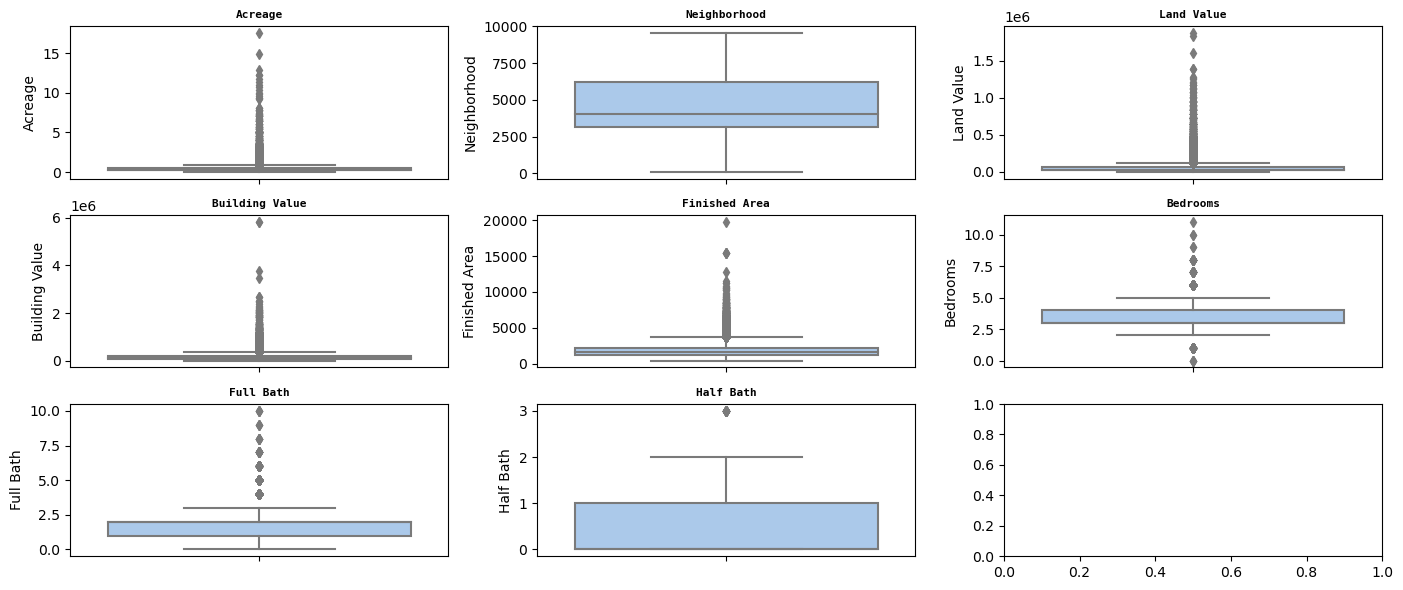

In [88]:
# Viewing outliers using box plots
# Selecting numeric columns we want to test for outliers
outlier_columns = ['Acreage', 'Neighborhood', 'Land Value', 'Building Value', 'Finished Area', 'Bedrooms', 'Full Bath', 'Half Bath']

# Making the plots
fig, ax = plt.subplots(3, 3, figsize=(14, 6))

for i, col in enumerate(outlier_columns):
    g = sns.boxplot(data=data, y=col, ax=ax[i // 3, i % 3], palette="pastel")
    g.set_title(col, weight="bold", fontsize=8, fontname="monospace")

plt.tight_layout()
plt.show()

In [89]:
# Get the summary statistics for all the columns
round(data.describe(), 2).transpose()

,count,mean,std,min,25%,50%,75%,max
Land Use,22539.0,2.84,0.67,0.00,3.0,3.00,3.00,3.00
Sold As Vacant,22539.0,0.01,0.08,0.00,0.0,0.00,0.00,1.00
Multiple Parcels Involved in Sale,22539.0,0.02,0.14,0.00,0.0,0.00,0.00,1.00
Acreage,22539.0,0.46,0.61,0.04,0.2,0.28,0.46,17.50
Neighborhood,22539.0,4435.53,2142.25,107.00,3130.0,4026.00,6229.00,9530.00
Land Value,22539.0,70221.16,103043.51,900.00,22000.0,30000.00,60300.00,1869000.00
Building Value,22539.0,172093.44,189828.25,1400.00,85500.0,118600.00,187800.00,5824300.00
Finished Area,22539.0,1914.46,1078.01,450.00,1248.0,1643.50,2213.00,19728.25
Foundation Type,22539.0,0.84,1.32,0.00,0.0,0.00,1.00,6.00
Year Built,22539.0,1961.91,25.78,1832.00,1947.0,1959.00,1977.00,2017.00


In [90]:
# Feature Engineering of new columns 

# Create a 'Total Property Value' column by adding the land value and the building value
data['Total Property Value'] = data['Land Value'] + data['Building Value']

# Get the year of sale and remove the sale date column
data['Sale Year'] = data['Sale Date'].dt.year
data = data.drop('Sale Date', axis=1)


C:\Users\fathima.sa\AppData\Local\Temp\ipykernel_16744\175243847.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


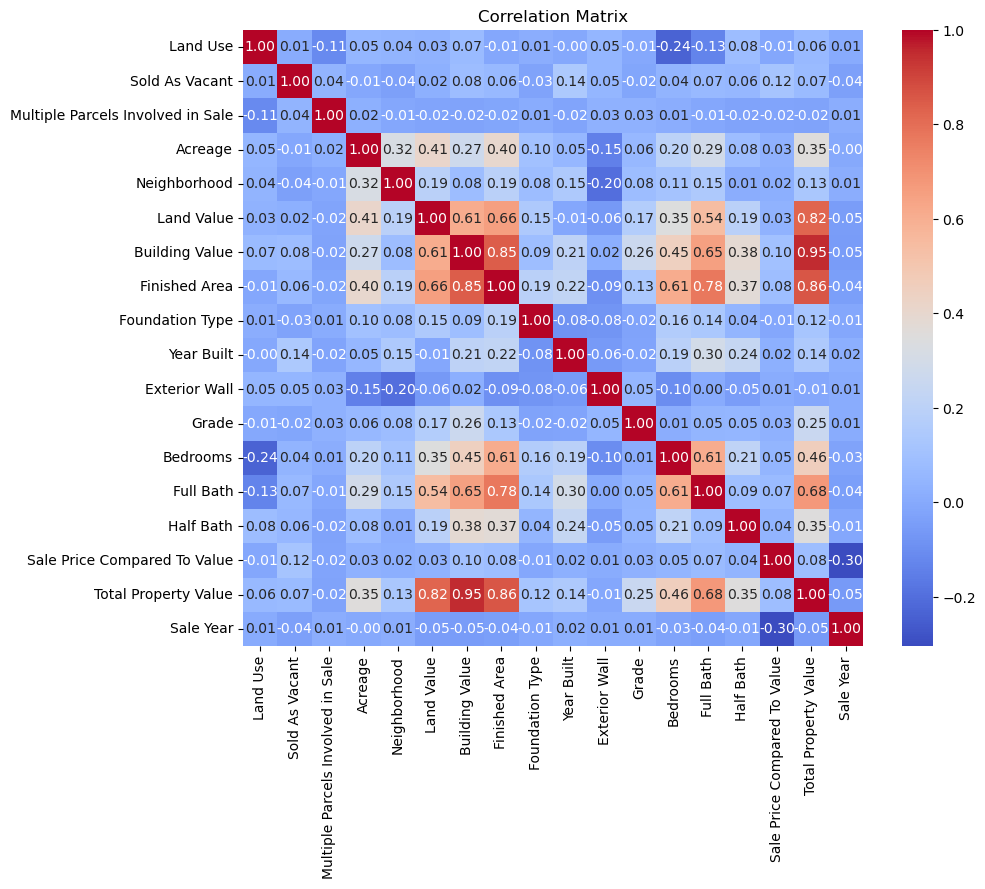

In [91]:
# Plotting the correlation matrix
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

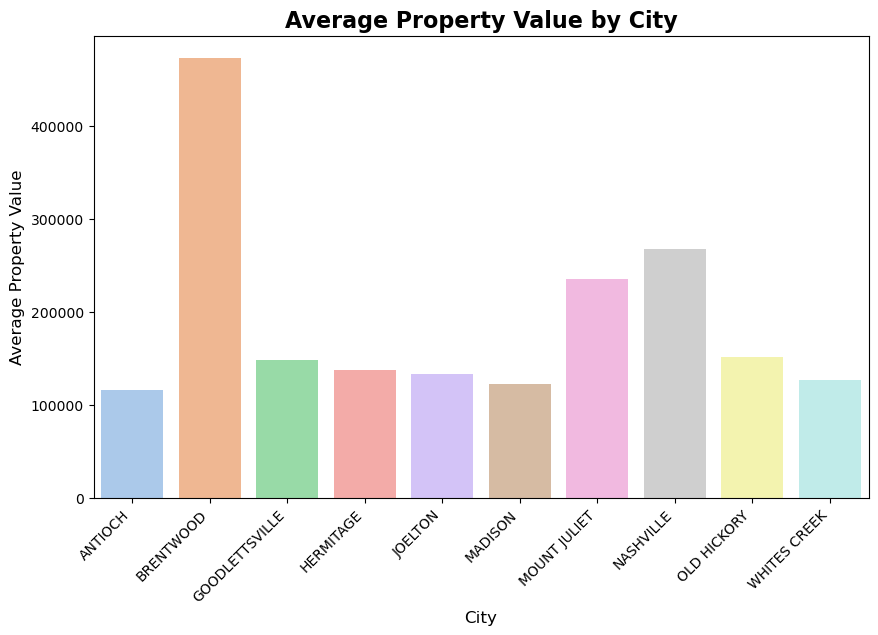

In [92]:
# Create a column chart to view the average property value for each city

# Calculate the average property value for each city
AvgPropertyValue = data.groupby('City')['Total Property Value'].mean().reset_index()

# Plotting the column chart
plt.figure(figsize=(10, 6))
sns.barplot(x='City', y='Total Property Value', data=AvgPropertyValue, palette='pastel')
plt.title('Average Property Value by City', fontsize=16, weight='bold')
plt.xlabel('City', fontsize=12)
plt.ylabel('Average Property Value', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


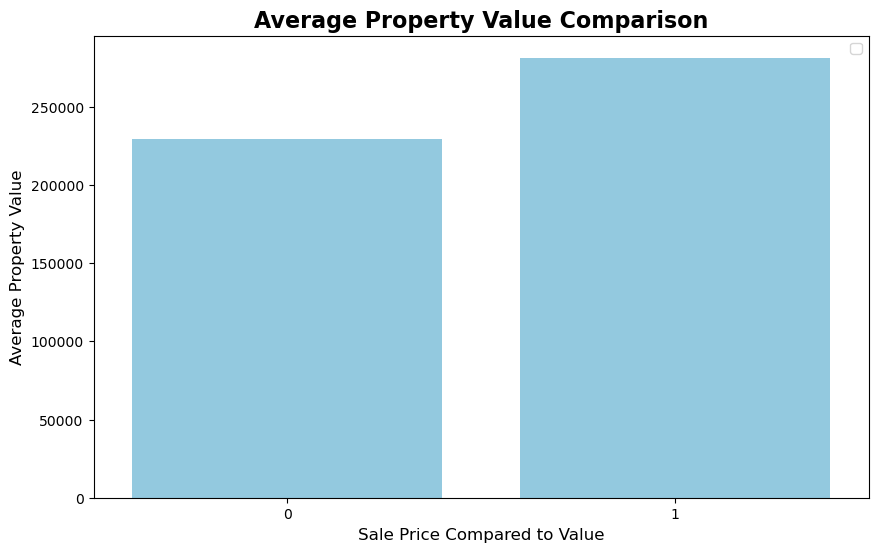

In [93]:
# Average property value by 'Sale Price Compared to Value'

# Calculate the average property value for sale price and value
AvgPropertyValue = data.groupby('Sale Price Compared To Value')['Total Property Value'].mean().reset_index()

# Plotting the horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Sale Price Compared To Value', y='Total Property Value', data=AvgPropertyValue, color='skyblue')
plt.title('Average Property Value Comparison', fontsize=16, weight='bold')
plt.ylabel('Average Property Value', fontsize=12)
plt.xlabel('Sale Price Compared to Value', fontsize=12)
plt.legend()
plt.show()



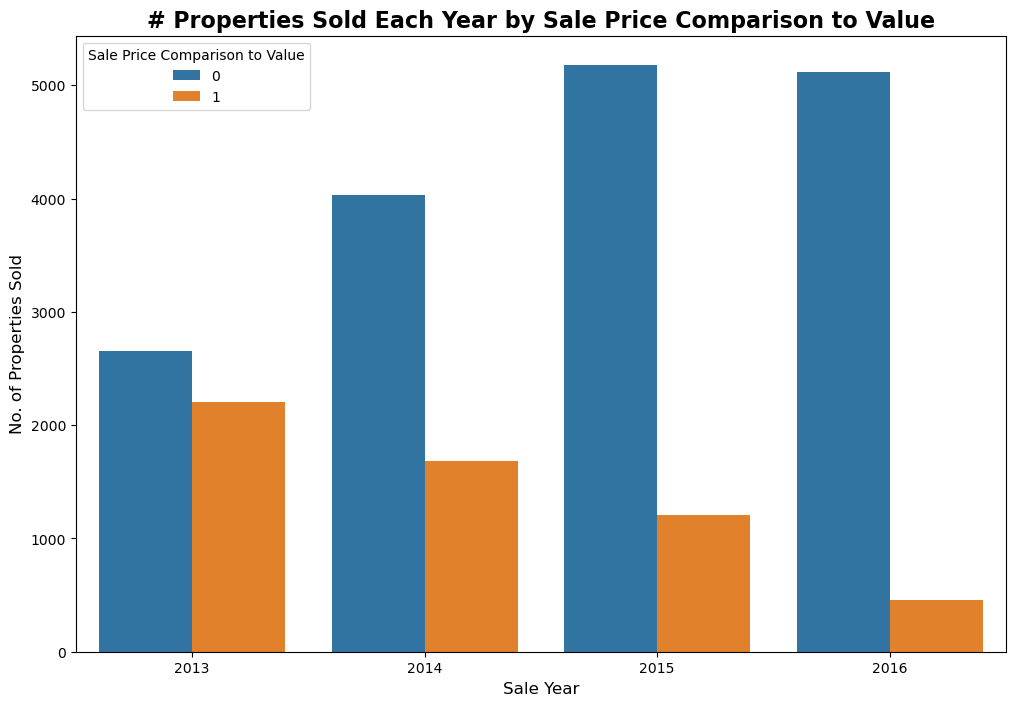

In [94]:
# Plotting the count of properties sold each year split by if they were sold for more than the value or less than the value

# Plotting the count of properties sold each 'sale year' split by 'sale_price_compared_to_value'
plt.figure(figsize=(12, 8))
sns.countplot(x='Sale Year', hue='Sale Price Compared To Value', data=data)
plt.title('# Properties Sold Each Year by Sale Price Comparison to Value', fontsize=16, weight='bold')
plt.xlabel('Sale Year', fontsize=12)
plt.ylabel('No. of Properties Sold', fontsize=12)
plt.legend(title='Sale Price Comparison to Value')
plt.show()


In [95]:
#########################    PART 2   #################################

In [96]:
# Remove the categorical variables city and tax district from the dataset before building the model
data.drop(['City', 'Tax District'], axis=1, inplace=True)

In [97]:
data.dtypes

Land Use                               int32
Sold As Vacant                         int32
Multiple Parcels Involved in Sale      int32
Acreage                              float64
Neighborhood                           int64
Land Value                             int64
Building Value                         int64
Finished Area                        float64
Foundation Type                        int32
Year Built                             int64
Exterior Wall                          int32
Grade                                  int32
Bedrooms                             float64
Full Bath                            float64
Half Bath                            float64
Sale Price Compared To Value           int32
Total Property Value                   int64
Sale Year                              int64
dtype: object

In [98]:
# Creating test and train datasets
# Taking 'Total Property Value' as the target variable and 'X' are the features
X = data.drop('Sale Price Compared To Value', axis=1)
y = data['Sale Price Compared To Value']

# Assuming 'X' is your feature matrix, and 'y' is the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [99]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [100]:
# Logistic regression model
logmodel = LogisticRegression(random_state=42)
logmodel.fit(X_train_scaled, y_train)

# Apply on test data
y_pred_log = logmodel.predict(X_test_scaled)

# Time taken for logistic regression model to make predictions
start_time = time.time()
log_time = time.time() - start_time

# Measure metrics of performance
accuracy_log = accuracy_score(y_test, y_pred_log)
classification_report_log = classification_report(y_test, y_pred_log)
conf_matrix = confusion_matrix(y_test, y_pred_log)

print(f'Logistic Regression Accuracy: {accuracy_log}')
print('Classification Report for Logistic Regression:')
print(classification_report_log)
print("Confusion Matrix:\n", conf_matrix)
print(log_time)

Logistic Regression Accuracy: 0.7648624667258208
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.77      0.98      0.86      3424
           1       0.57      0.09      0.15      1084

    accuracy                           0.76      4508
   macro avg       0.67      0.53      0.51      4508
weighted avg       0.72      0.76      0.69      4508

Confusion Matrix:
 [[3355   69]
 [ 991   93]]
0.0


In [101]:
#########################    PART 3   #################################

In [102]:
# Decision tree model
DT_model = DecisionTreeClassifier(random_state=42)
DT_model.fit(X_train_scaled, y_train)

# Make predictions on test set
y_pred_DT = DT_model.predict(X_test_scaled)

# Time taken for logistic regression model to make predictions
start_time = time.time()
DT_time = time.time() - start_time

# Model performance
accuracy_DT = accuracy_score(y_test, y_pred_DT)
classification_report_DT = classification_report(y_test, y_pred_DT)
conf_matrix_DT = confusion_matrix(y_test, y_pred_DT)

print(f'Decision Tree Accuracy: {accuracy_DT}')
print('Classification Report for Decision Tree:')
print(classification_report_DT)
print("Confusion Matrix:\n", conf_matrix_DT)
print(DT_time)

Decision Tree Accuracy: 0.7094055013309671
Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81      3424
           1       0.40      0.41      0.41      1084

    accuracy                           0.71      4508
   macro avg       0.61      0.61      0.61      4508
weighted avg       0.71      0.71      0.71      4508

Confusion Matrix:
 [[2750  674]
 [ 636  448]]
0.0


In [103]:
#########################    PART 4   #################################

In [104]:
# Random forest model
RF_model = RandomForestClassifier(random_state=42)
RF_model.fit(X_train_scaled, y_train)

# Apply model
y_pred_RF = RF_model.predict(X_test_scaled)

# Time taken for logistic regression model to make predictions
start_time = time.time()
RF_time = time.time() - start_time

# Evaluate the model
accuracy_RF = accuracy_score(y_test, y_pred_RF)
classification_report_RF = classification_report(y_test, y_pred_RF)
conf_matrix_RF = confusion_matrix(y_test, y_pred_RF)

print(f'Random Forest Accuracy: {accuracy_RF}')
print('Classification Report for Random Forest:')
print(classification_report_RF)
print("Confusion Matrix:\n", conf_matrix_RF)
print(RF_time)

Random Forest Accuracy: 0.7775066548358474
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      3424
           1       0.57      0.31      0.40      1084

    accuracy                           0.78      4508
   macro avg       0.69      0.62      0.63      4508
weighted avg       0.75      0.78      0.75      4508

Confusion Matrix:
 [[3164  260]
 [ 743  341]]
0.0


In [105]:
#########################    PART 5   #################################

In [106]:
# Gradient boost model
GB_model = GradientBoostingClassifier(random_state=42)
GB_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_GB = GB_model.predict(X_test_scaled)

# Time taken for logistic regression model to make predictions
start_time = time.time()
GB_time = time.time() - start_time

# Evaluate the model
accuracy_GB = accuracy_score(y_test, y_pred_GB)
classification_report_GB = classification_report(y_test, y_pred_GB)
conf_matrix_GB = confusion_matrix(y_test, y_pred_GB)

print(f'Gradient Boost Accuracy: {accuracy_GB}')
print('Classification Report for Gradient Boost:')
print(classification_report_GB)
print("Confusion Matrix:\n", conf_matrix_GB)
print(GB_time)


Gradient Boost Accuracy: 0.7879325643300799
Classification Report for Gradient Boost:
              precision    recall  f1-score   support

           0       0.80      0.97      0.87      3424
           1       0.68      0.23      0.34      1084

    accuracy                           0.79      4508
   macro avg       0.74      0.60      0.61      4508
weighted avg       0.77      0.79      0.74      4508

Confusion Matrix:
 [[3308  116]
 [ 840  244]]
0.0


In [107]:
# Create a comparsion matrix for the above 4 models
metrics_data = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boost'],
    'Precision': [precision_score(y_test, y_pred_log), precision_score(y_test, y_pred_DT),
                  precision_score(y_test, y_pred_RF), precision_score(y_test, y_pred_GB)],
    'Recall': [recall_score(y_test, y_pred_log), recall_score(y_test, y_pred_DT),
               recall_score(y_test, y_pred_RF), recall_score(y_test, y_pred_GB)],
    'F1-Score': [f1_score(y_test, y_pred_log), f1_score(y_test, y_pred_DT),
                 f1_score(y_test, y_pred_RF), f1_score(y_test, y_pred_GB)],
    'Accuracy': [accuracy_score(y_test, y_pred_log), accuracy_score(y_test, y_pred_DT),
                 accuracy_score(y_test, y_pred_RF), accuracy_score(y_test, y_pred_GB)],
    'ROC-AUC-Score': [roc_auc_score(y_test, y_pred_log), roc_auc_score(y_test, y_pred_DT),
                 roc_auc_score(y_test, y_pred_RF), roc_auc_score(y_test, y_pred_GB)]
}

ComparsionMatrix = pd.DataFrame(metrics_data)

print(ComparsionMatrix)


                 Model  Precision    Recall  F1-Score  Accuracy  ROC-AUC-Score
0  Logistic Regression   0.574074  0.085793  0.149278  0.764862       0.532821
1        Decision Tree   0.399287  0.413284  0.406165  0.709406       0.608219
2        Random Forest   0.567388  0.314576  0.404748  0.777507       0.619321
3       Gradient Boost   0.677778  0.225092  0.337950  0.787933       0.595607


In [108]:
# Compare the time taken for the models to make predictions

# Print the benchmark results
print(f'Logistic Regression Time: {log_time} seconds')
print(f'Decision Tree Time: {DT_time} seconds')
print(f'Random Forest Time: {RF_time} seconds')
print(f'Gradient Boost Time: {GB_time} seconds')


Logistic Regression Time: 0.0 seconds
Decision Tree Time: 0.0 seconds
Random Forest Time: 0.0 seconds
Gradient Boost Time: 0.0 seconds


In [110]:
# Getting p-values from logistic regression model to identify significant features

import statsmodels.api as sm

X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit logistic regression model
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# Get p-values
p_values = result.pvalues
print("Logistic Regression P-values:")
print(p_values)

# Get coefficients
coefficients = result.params
print("Logistic Regression Coefficients:")
print(coefficients)

         Current function value: 0.502385
         Iterations: 35
Logistic Regression P-values:
const                                0.000000e+00
Land Use                             2.876030e-02
Sold As Vacant                       7.308051e-22
Multiple Parcels Involved in Sale    1.465817e-03
Acreage                              2.016080e-02
Neighborhood                         4.852038e-04
Land Value                                    NaN
Building Value                                NaN
Finished Area                        8.947480e-02
Foundation Type                      7.079765e-03
Year Built                           1.075940e-02
Exterior Wall                        2.325255e-01
Grade                                1.322473e-01
Bedrooms                             2.291749e-01
Full Bath                            7.579763e-01
Half Bath                            7.824851e-01
Total Property Value                          NaN
Sale Year                            0.000000e+00
dtyp

C:\Users\fathima.sa\AppData\Local\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [111]:
# For tree-based models p-values are required

# Feature importances - Decision Trees
feature_importances_DT = DT_model.feature_importances_
print("Decision Tree Feature Importances:")
print(feature_importances_DT)

# Feature importances - Random Forest
feature_importances_RF = RF_model.feature_importances_
print("Random Forest Feature Importances:")
print(feature_importances_RF)

# Feature importances - Gradient Boost
feature_importances_GB = GB_model.feature_importances_
print("Gradient Boosting Feature Importances:")
print(feature_importances_GB)

Decision Tree Feature Importances:
[0.00527057 0.00383451 0.00408215 0.10457576 0.06743001 0.0810826
 0.1231447  0.1462552  0.02593777 0.13089589 0.01879061 0.01369786
 0.02496133 0.0240981  0.01374748 0.10158205 0.11061341]
Random Forest Feature Importances:
[0.00680426 0.00866633 0.00406931 0.09938069 0.07525192 0.08842729
 0.12351299 0.11977475 0.02567947 0.11295149 0.02373176 0.01344517
 0.02757921 0.02352787 0.01467946 0.11942441 0.11309361]
Gradient Boosting Feature Importances:
[3.63593669e-03 2.08773436e-02 5.91835489e-03 2.59693922e-02
 2.56597322e-02 1.11575805e-01 6.50965719e-02 2.86230706e-02
 2.50178701e-03 1.89008191e-01 1.51361685e-03 4.62189955e-03
 3.53518608e-03 4.68142973e-03 1.60219296e-04 2.06002717e-02
 4.86021192e-01]


In [114]:
# Create a to compare feature importances

# Column names
column_names = ['LandUse', 'SoldAsVacant', 'MultipleParcelsInvolvedinSale', 'Acreage', 'Neighborhood', 'LandValue',
                'BuildingValue', 'FinishedArea', 'FoundationType', 'YearBuilt', 'ExteriorWall', 'Grade', 'Bedrooms',
                'FullBath', 'HalfBath', 'TotalPropertyValue', 'SaleYear']

feature_importance_matrix = pd.DataFrame(data=np.vstack([feature_importances_DT, feature_importances_RF, feature_importances_GB]),
                                         columns=column_names,
                                         index=['Decision Tree', 'Random Forest', 'Gradient Boosting'])

# Print the matrix
print("Feature Importance Matrix:")
print(feature_importance_matrix.transpose())

Feature Importance Matrix:
                               Decision Tree  Random Forest  Gradient Boosting
LandUse                             0.005271       0.006804           0.003636
SoldAsVacant                        0.003835       0.008666           0.020877
MultipleParcelsInvolvedinSale       0.004082       0.004069           0.005918
Acreage                             0.104576       0.099381           0.025969
Neighborhood                        0.067430       0.075252           0.025660
LandValue                           0.081083       0.088427           0.111576
BuildingValue                       0.123145       0.123513           0.065097
FinishedArea                        0.146255       0.119775           0.028623
FoundationType                      0.025938       0.025679           0.002502
YearBuilt                           0.130896       0.112951           0.189008
ExteriorWall                        0.018791       0.023732           0.001514
Grade                    